# Titanic Logistic Regression

### In this notebook I developed a Logistic regression model that can predict whether a Titanic passenger survived or not based on multiple features

### I used the Titanic dataset that cantains the following columns:
- **PassengerId** which is the id of each passenger.
- **Survived** which indicates whether the passenger survived or not(0 = didn't survive,1=survived)
- **Pclass** which is the class level that the passenger travelled in.
- **Name** of each passenger.
- **Sex** of each passenger.
- **Age** of each passenger.
- **SibSP** which indicates the number of siblings/spouses of each passenger.
- **Parch** which indicates the number of parents/children of each passenger.
- **Ticket** of each passenger.
- **Fare** which is basically the price of the ticket paid.
- **Cabin** where each passenger stayed in.
- **Embarked** which is the port of embarkment.

## Importing Libraries and Reading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

In [3]:
ID = titanic_test['PassengerId']
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace = True) #Dropping useless columns
titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Data Wrangling (Train)

In [5]:
titanic_train.shape

(891, 8)

In [6]:
titanic_train.isna().sum() #Check for missing values

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
titanic_train.dtypes #Check datatypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [8]:
titanic_train.corr() #Check correlations

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [9]:
titanic_train.describe() #Inspect numerical data

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Looks like the **Fare** column has outliers.

In [10]:
titanic_train['Embarked'].value_counts() 

S    644
C    168
Q     77
Name: Embarked, dtype: int64

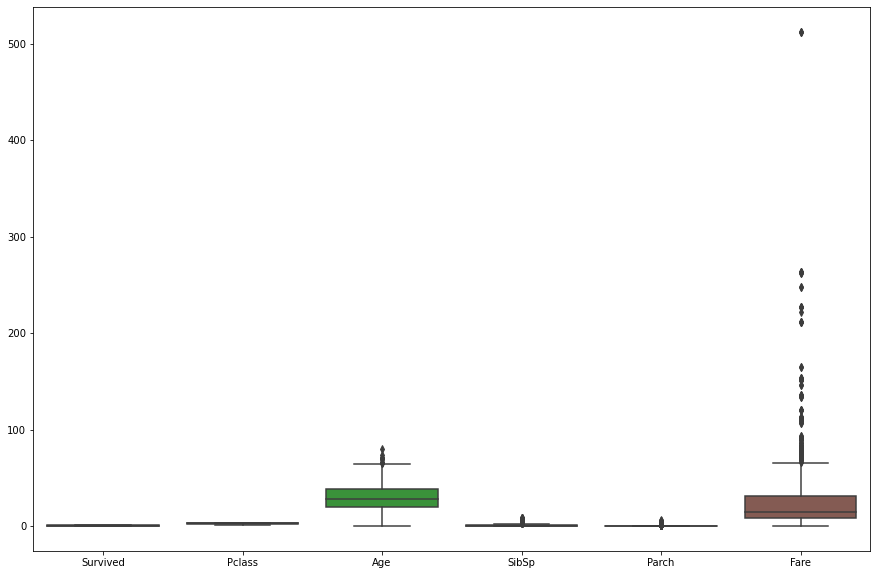

In [11]:
plt.figure(figsize=(15,10))
sns.boxplot(data=titanic_train);  #Boxplot to inspect outliers
plt.show()

### Wrangling summary of train data:
- Multiple missing values in **Age** column and 2 missing values in **Embarked** column.
- Outliers in **Fare** column

## Data Cleaning

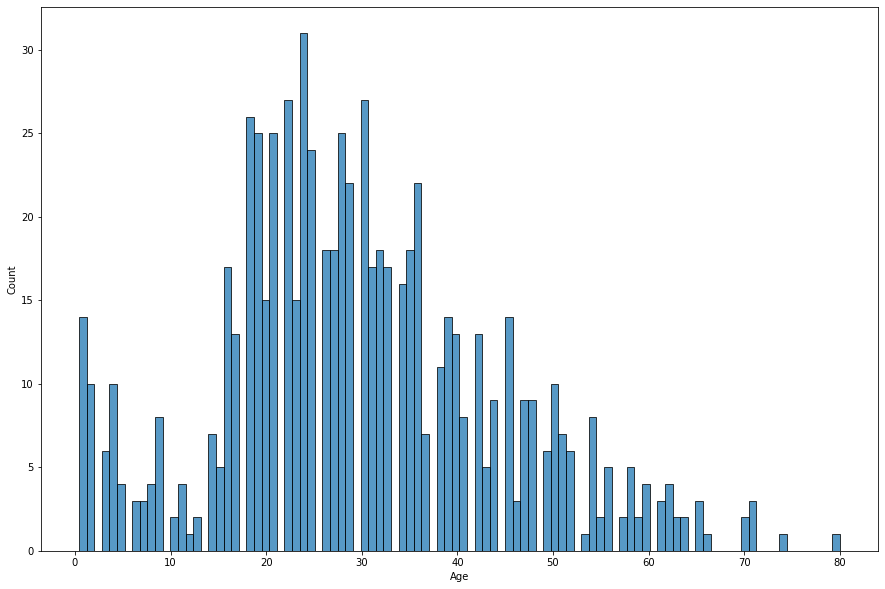

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(x='Age',data=titanic_train,bins=100);  ##Inspect distribution of Age column
plt.show()

Since the data is somewhat normally distributed I will replace missing values with the mean.

In [13]:
titanic_train['Age'].fillna(titanic_train['Age'].mean(),inplace = True) #Replacing with mean

In [14]:
fare = titanic_train['Fare']
fare_q1 = fare.quantile(0.2)            # Creating boundaries for outliers
fare_q3 = fare.quantile(0.8)
fare_iqr = fare_q3 - fare_q1
lowerbound = fare_q1 - (1.5 * fare_iqr)
upperbound = fare_q3 + (1.5 * fare_iqr)
lowerbound,upperbound

(-39.89575, 87.43745)

In [15]:
outliers = fare[(fare < lowerbound) | (fare > upperbound)]  
outliers

27     263.0000
31     146.5208
88     263.0000
118    247.5208
195    146.5208
         ...   
779    211.3375
802    120.0000
820     93.5000
849     89.1042
856    164.8667
Name: Fare, Length: 63, dtype: float64

In [16]:
titanic_train.loc[titanic_train['Fare'] > 87,'Fare'] = None #Setting outliers to Nan

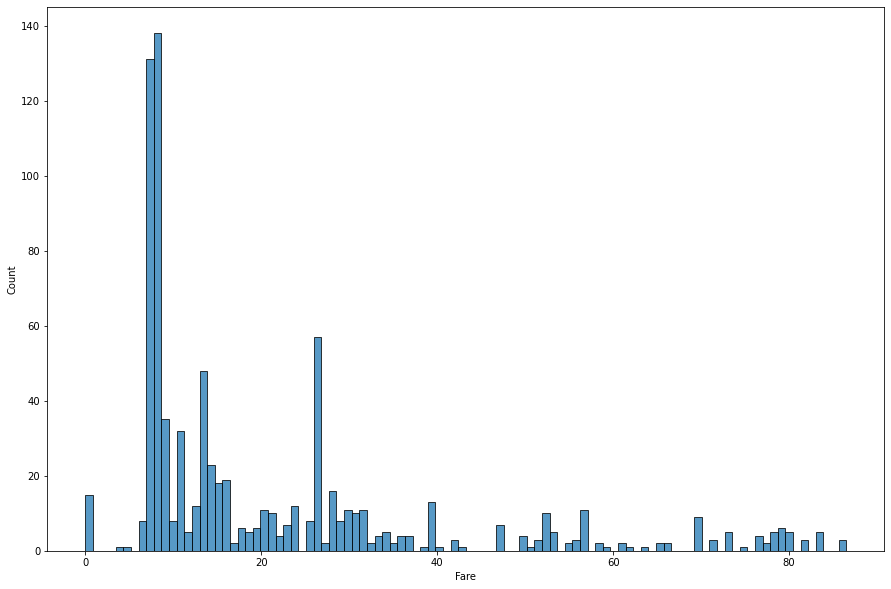

In [17]:
plt.figure(figsize=(15,10))
sns.histplot(x='Fare',data=titanic_train,bins=100); #Inspect distribution of Fare column
plt.show()

Data is right skewed so it's better to replace missing with the median.

In [18]:
titanic_train['Fare'].fillna(titanic_train['Fare'].median(),inplace = True) #Replacing Nan with median in Fare column

In [19]:
titanic_train['Embarked'].fillna(titanic_train['Embarked'].mode()[0],inplace = True) #Replacing Nan with mode in Embarked column

In [20]:
titanic_train.isna().sum()  #Making sure all missing values are handled

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [21]:
titanic_train.shape #Making sure the shape of the data is unchanged

(891, 8)

## Data Wrangling (Test)

In [22]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [23]:
titanic_test.drop(['PassengerId','Name','Ticket','Cabin'],axis =1,inplace = True) 

In [24]:
titanic_test.shape

(418, 7)

In [25]:
titanic_test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [26]:
titanic_test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


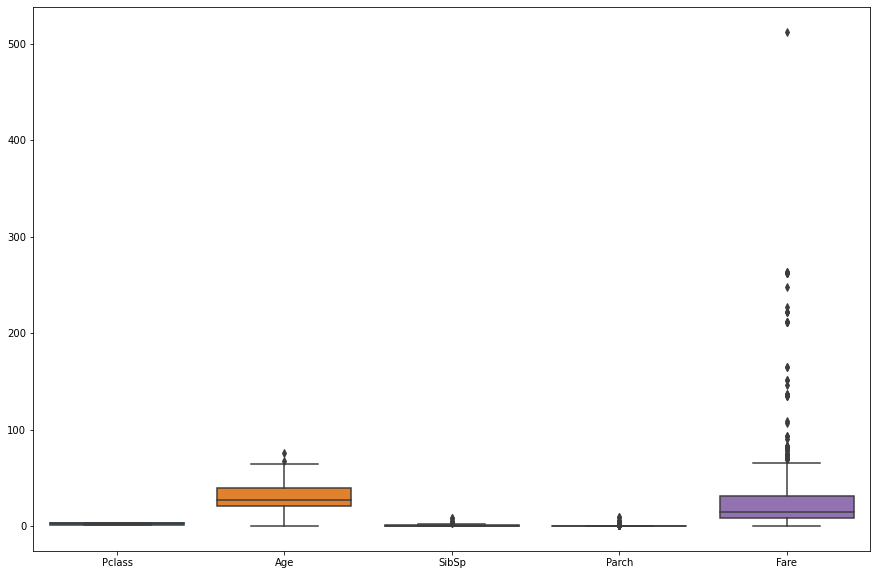

In [27]:
plt.figure(figsize=(15,10))
sns.boxplot(data=titanic_test);
plt.show()

### Wrangling Summary of test data.
- Multiple missing values in **Age** column and 1 missing value in **Fare** column.
- Outliers in **Fare** column.

## Data Cleaning (Test)

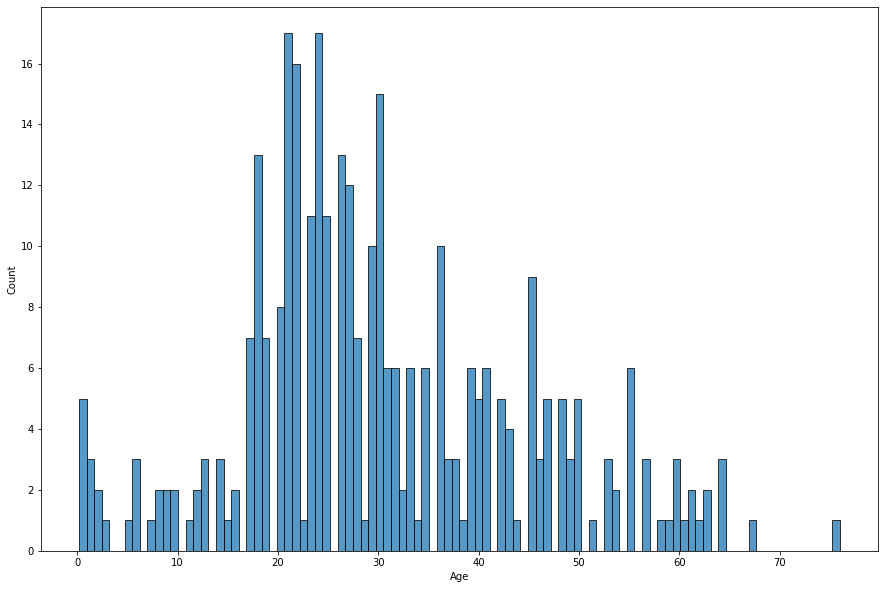

In [28]:
plt.figure(figsize=(15,10))
sns.histplot(x='Age',data=titanic_test,bins=100); #Inspect distribution of Age column
plt.show()

Since the distribution is slightly right-skewed I will replace missing values with the median.

In [29]:
titanic_test['Age'].fillna(titanic_test['Age'].median(),inplace=True) 

In [30]:
fare = titanic_test['Fare']
fare_q1 = fare.quantile(0.2)
fare_q3 = fare.quantile(0.8)           #Creating boundaries for outliers
fare_iqr = fare_q3 - fare_q1
lowerbound = fare_q1 - (1.5 * fare_iqr)
upperbound = fare_q3 + (1.5 * fare_iqr)
lowerbound,upperbound

(-50.440500000000014, 104.85630000000003)

In [31]:
outliers = fare[(fare < lowerbound) | (fare > upperbound)]
outliers.count()

31

In [32]:
titanic_test.loc[titanic_test['Fare'] > 105,'Fare'] = None  #Removing outliers

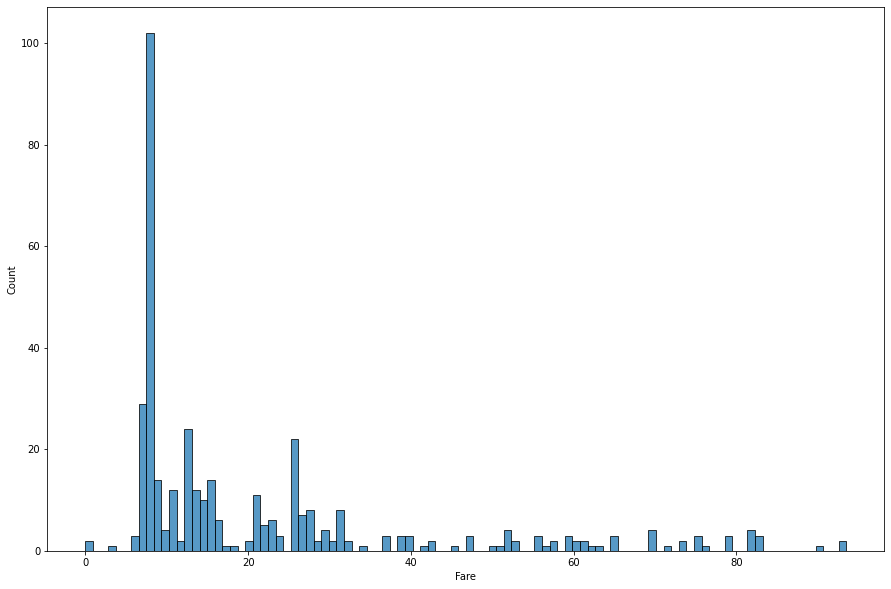

In [33]:
plt.figure(figsize=(15,10))
sns.histplot(x='Fare',data=titanic_test,bins=100); #Inspect distribution of Fare column
plt.show()

Data is right skewed so it's better to replace missing with the median.

In [34]:
titanic_test['Fare'].fillna(titanic_test['Fare'].median(),inplace=True) #Replacing Nan with median

In [35]:
titanic_test.isna().sum() #Making sure all missing values are handled

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [36]:
titanic_test.shape #Making sure the shape of the data is unchanged

(418, 7)

## Implementing Logistic Regression

First Implementing One Hot Encoding to **Sex** & **Embarked** columns in both train and test data.

In [37]:
encoder = OneHotEncoder(handle_unknown = 'ignore')  
encoder_sex = pd.DataFrame(encoder.fit_transform(titanic_train[['Sex']]).toarray()) #OneHot encoding
titanic_train = titanic_train.join(encoder_sex)
titanic_train.drop('Sex',axis=1,inplace = True)

In [38]:
titanic_train.rename(columns = {titanic_train.columns[7]:'female',titanic_train.columns[8]:'male'},inplace=True) #Renaming columns creaed from encoding

In [39]:
encoder_embark = pd.DataFrame(encoder.fit_transform(titanic_train[['Embarked']]).toarray())
titanic_train = titanic_train.join(encoder_embark)
titanic_train.drop('Embarked',axis=1,inplace=True)

In [40]:
titanic_train.rename(columns = {titanic_train.columns[8]:'C',titanic_train.columns[9]:'Q',titanic_train.columns[10]:'S'},inplace=True)
titanic_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [41]:
encoder_sex = pd.DataFrame(encoder.fit_transform(titanic_test[['Sex']]).toarray())
titanic_test = titanic_test.join(encoder_sex)
titanic_test.drop('Sex',axis=1,inplace = True)

In [42]:
titanic_test.rename(columns = {titanic_test.columns[6]:'female',titanic_test.columns[7]:'male'},inplace=True)

In [43]:
encoder_embark = pd.DataFrame(encoder.fit_transform(titanic_test[['Embarked']]).toarray())
titanic_test = titanic_test.join(encoder_embark)
titanic_test.drop('Embarked',axis=1,inplace=True)

In [44]:
titanic_test.rename(columns = {titanic_test.columns[7]:'C',titanic_test.columns[8]:'Q',titanic_test.columns[9]:'S'},inplace=True)
titanic_test.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0


Implementing Logistic Regression

In [45]:

x_train = titanic_train.drop('Survived',axis=1) #Splitting Features and Target
y_train = titanic_train['Survived']

In [46]:
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train,y_train)                    #Calling logistic regression

y_pred = logreg.predict(titanic_test)

C:\Users\mancr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
pred = pd.DataFrame({'PassengerId':ID,'Survived':y_pred}) #Creating prediction dataframe
pred.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [48]:
pred.to_csv('Prediction.csv',index=False)